In [1]:
import pandas as pd 
import numpy as np
import joblib
import pickle
from Utils.Transformer import Transformer

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from Utils.Transformer import Transformer
from Utils.label_encoder import label_encoder

from IPython.display import display, Markdown
from scipy.stats import *

import sklearn as sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, accuracy_score,precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix

import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

%matplotlib inline

In [2]:
df_raw = pd.read_pickle("./data/df_proper_cleaned.pkl")

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163955 entries, 0 to 167782
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                163955 non-null  int64  
 1   userId            163955 non-null  int64  
 2   gender            163955 non-null  object 
 3   sport             163955 non-null  object 
 4   heart_rate_mean   163955 non-null  float64
 5   heart_rate_std    163955 non-null  float64
 6   duration_s        163955 non-null  float64
 7   start_end         163955 non-null  object 
 8   altitude_mean     163955 non-null  float64
 9   altitude_std      163955 non-null  float64
 10  ascend_m          163955 non-null  float64
 11  descend_m         163955 non-null  float64
 12  distance_mean_m   163955 non-null  float64
 13  distance_std_m    163955 non-null  float64
 14  distance_total_m  163955 non-null  float64
 15  speed_mean        163955 non-null  float64
 16  speed_std         16

In [4]:
df_raw.sport.value_counts().index

Index(['bike', 'run', 'mountain bike', 'bike (transport)', 'indoor cycling',
       'walk', 'orienteering', 'cross-country skiing',
       'core stability training', 'fitness walking', 'skate', 'roller skiing',
       'hiking', 'circuit training', 'kayaking', 'rowing', 'weight training',
       'soccer', 'downhill skiing', 'gymnastics'],
      dtype='object')

# Modeling

In [5]:
from Utils.Transformer import Transformer

'''
class Transformer(object):
    def __init__(self, fillnan=True):
        self._NAME_ = 'Transformer'
        
        # categorical features to dummify and then drop
        self.feature_categorical = ['userId', 'gender','sport']
        
        # numeric features to keep
        self.feature_numeric = ['heart_rate_mean', 'heart_rate_std', 
                                   'altitude_mean', 'altitude_std',
                                   'ascend_m', 'descend_m', 'distance_total_m',
                                   'speed_mean','speed_std','duration_s','calories']
        
        # from the top 20 sport list
        self.sports = ['bike', 'run', 'mountain bike', 'bike (transport)', 'indoor cycling',
                       'walk', 'orienteering', 'cross-country skiing',
                       'core stability training', 'fitness walking', 'skate', 'roller skiing',
                       'hiking', 'circuit training', 'kayaking', 'rowing', 'weight training',
                       'soccer', 'downhill skiing', 'gymnastics']
        
        self.gender = ['male','female','unknown']
        
        self.FILLNAN = fillnan
        
    def fit(self, X, y=None):
        if self.FILLNAN:
            col_list = list(set(X.columns) & set(self.feature_numeric))
            self.mean = X[col_list].mean()
        
    def transform(self, X, y=None):
        features = X.columns
        df = pd.DataFrame()
        for feature in features:
            if feature =='start_time':
                date = pd.to_datetime(X[feature])
                #df['year'] = date.dt.year
                df['month'] = date.dt.month
                df['weekday'] = date.dt.weekday
            if feature =='gender':
                for g in self.gender:
                    df[g] = (X[feature]==g).astype(int)
                    
            if feature == 'sport': # dummy transform onto fixed categorical labels
                for s in self.sports:
                    df[s] = (X[feature]==s).astype(int)
            
            if feature in self.feature_numeric:
                df[feature] = X[feature]
        
        if hasattr(self, 'mean') and self.FILLNAN:
            df = df.fillna(self.mean)
            
        # engineering new features
        #if {'calories', 'duration_s'}.issubset(df.columns):
        #    df['calories_rate'] = (1000*df['calories'])/df['duration_s']
        
        return df
        
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
'''       
df_transformed = Transformer(fillnan=True).fit_transform(df_raw)
print(df_transformed.info())
df_transformed.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163955 entries, 0 to 167782
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   male                     163955 non-null  int64  
 1   female                   163955 non-null  int64  
 2   unknown                  163955 non-null  int64  
 3   bike                     163955 non-null  int64  
 4   run                      163955 non-null  int64  
 5   mountain bike            163955 non-null  int64  
 6   bike (transport)         163955 non-null  int64  
 7   indoor cycling           163955 non-null  int64  
 8   walk                     163955 non-null  int64  
 9   orienteering             163955 non-null  int64  
 10  cross-country skiing     163955 non-null  int64  
 11  core stability training  163955 non-null  int64  
 12  fitness walking          163955 non-null  int64  
 13  skate                    163955 non-null  int64  
 14  roll

,male,female,unknown,bike,run,mountain bike,bike (transport),indoor cycling,walk,orienteering,...,altitude_mean,altitude_std,ascend_m,descend_m,distance_total_m,speed_mean,speed_std,calories,month,weekday
0,1,0,0,1,0,0,0,0,0,0,...,43.0712,13.475900,407.6,413.0,53049.413644,7.117435,2.182678,1563.0,8,6
1,1,0,0,1,0,0,0,0,0,0,...,35.7248,10.376062,225.4,228.8,32467.566953,7.550103,2.272863,909.0,8,5
2,1,0,0,1,0,0,0,0,0,0,...,62.4256,13.217515,328.8,352.4,45309.570377,7.154326,2.150951,1139.0,8,1
3,1,0,0,1,0,0,0,0,0,0,...,32.6104,11.417463,242.8,238.6,32529.910062,7.416873,2.201268,922.0,8,3
4,1,0,0,0,0,0,1,0,0,0,...,22.7620,8.383674,89.6,107.4,11936.117059,8.721936,2.388718,351.0,8,4


## Data Split: train/test, features/target

In [6]:
# features to be scaled within individual user
'''
feature_scale = ['heart_rate_mean','speed_mean','calories']
userId = df_raw.userId.value_counts().index
for user in userId:
    index = df_raw.userId==user
    temp = df_raw[index]
    for feature in feature_scale:
        mean = np.nanmean(temp[feature])
        std = np.nanstd(temp[feature])
        #print(mean,std)
        df_raw.loc[index, feature] = (temp[feature].values - mean)/std 
'''

"\nfeature_scale = ['heart_rate_mean','speed_mean','calories']\nuserId = df_raw.userId.value_counts().index\nfor user in userId:\n    index = df_raw.userId==user\n    temp = df_raw[index]\n    for feature in feature_scale:\n        mean = np.nanmean(temp[feature])\n        std = np.nanstd(temp[feature])\n        #print(mean,std)\n        df_raw.loc[index, feature] = (temp[feature].values - mean)/std \n"

In [7]:
train_raw, test_raw = train_test_split(df_raw.reset_index(drop=True), test_size=0.1, random_state=42)
print(df_raw.shape)
print(train_raw.shape)
print(test_raw.shape)

(163955, 21)
(147559, 21)
(16396, 21)


In [8]:
target = 'calories'
features = ['sport', 'gender', 'heart_rate_mean', 'heart_rate_std', 'altitude_mean',
           'altitude_std', 'ascend_m', 'descend_m', 'distance_total_m',
           'speed_mean', 'speed_std', 'duration_s', 'calories', 'start_time']

features.remove(target)

target_limit = np.percentile(df_raw[target],[.01,99.9])

## A linear regression model with Ridge regularization

In [11]:
'''
steps = [('transformer', Transformer()),
         ('poly', PolynomialFeatures()),
         ('rescale',RobustScaler()), 
         #('pca', PCA()),
         ('lr', Ridge())]

model = Pipeline(steps)

param_grid = {'poly__degree': [2], # 2 
              #'pca__n_components': [20], 
              'lr__alpha': [1], #1，5，10
              }

search = GridSearchCV(estimator = model, 
                      param_grid = param_grid, 
                      scoring= 'neg_mean_squared_error', 
                      cv = 5, n_jobs = -1, 
                      verbose=1, error_score = 'raise')

search.fit(train_raw[features], train_raw[target])
joblib.dump(search, 'gs_model_lr.pkl')

print(f'Best={search.best_params_}')
'''
search = joblib.load("./trained_models/gs_model_lr.pkl")
y_train_pred_lr = search.predict(train_raw[features])
y_test_pred_lr = search.predict(test_raw[features])

In [ ]:
#from sklearn.inspection import permutation_importance
#r = permutation_importance(search.best_estimator_['lr'], train_raw[features], test_raw[features],
#                            n_repeats=30, random_state=0)

In [14]:
search.best_estimator_['lr'].coef_.shape

(666,)

======== Linear Regression with Ridge ===========
Best={'lr__alpha': 1, 'poly__degree': 2}, Best score = -1.21e+05
mean_absolute_error on Train set =  1.85e+02
mean_absolute_error on  Test set =  1.88e+02
mean_squared_error on Train set =  9.68e+04
mean_squared_error on  Test set =  1.05e+05
r2_score on Train set =  7.52e-01
r2_score on  Test set =  7.38e-01
======== Linear Regression ===========
MAE =  1.85e+02       
MSE =  1.05e+05, 
R2 =  0.738


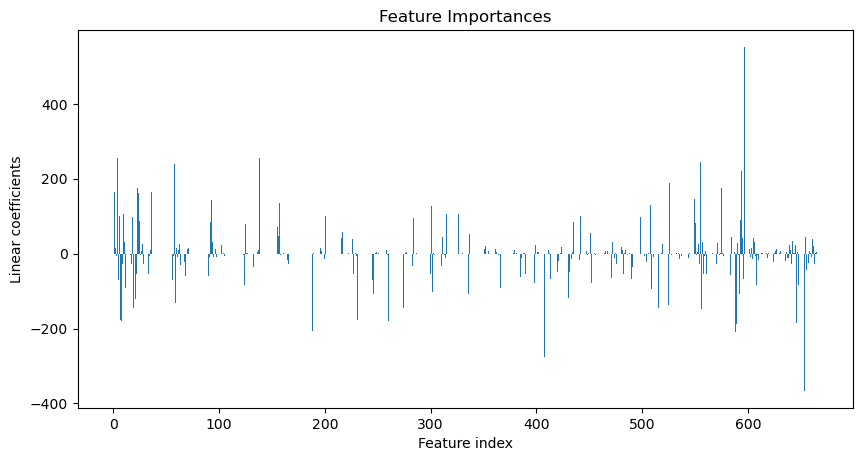

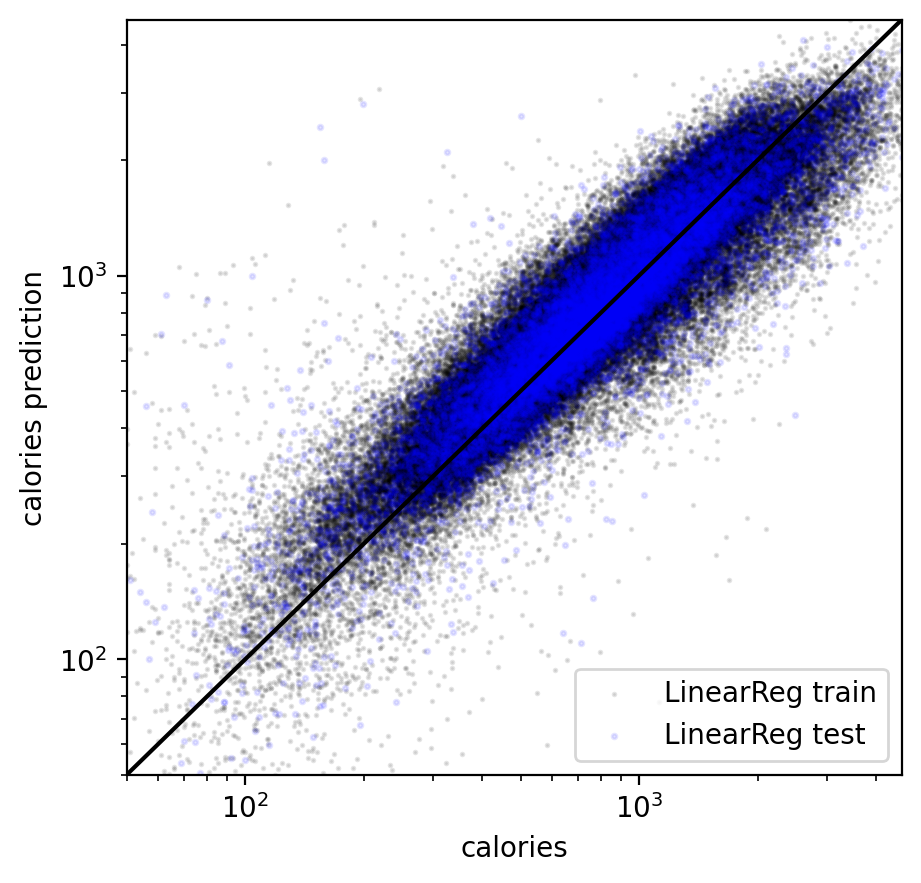

In [16]:
print('======== Linear Regression with Ridge ===========')
print(f'Best={search.best_params_}, Best score = {search.best_score_: .2e}')
all_metrics = [mean_absolute_error, mean_squared_error, r2_score]
for metrics in all_metrics:
    print(f'{metrics.__name__} on Train set = {metrics(train_raw[target], y_train_pred_lr): .2e}')
    print(f'{metrics.__name__} on  Test set = {metrics(test_raw[target], y_test_pred_lr): .2e}')
R2 = r2_score(test_raw[target], y_test_pred_lr)
adjusted_R2 = 1.0 - (1.0 - R2)*(len(test_raw)-1.0)/(len(test_raw)-len(features))
print('======== Linear Regression ===========')
print(f"MAE = {mean_absolute_error(train_raw[target], y_train_pred_lr): .2e} \
      \nMSE = {mean_squared_error(test_raw[target], y_test_pred_lr): .2e}, \nR2 = {R2: .3f}")

plt.figure(figsize=(10,5), dpi=100)
plt.bar(np.arange(len(search.best_estimator_['lr'].coef_)),  search.best_estimator_['lr'].coef_)
plt.title('Feature Importances'), plt.xlabel('Feature index'), plt.ylabel('Linear coefficients');

plt.figure(figsize=(5,5),dpi=200)
plt.scatter(train_raw[target], y_train_pred_lr, c = 'k', s = 1, alpha = 0.1, label ='LinearReg train')
plt.scatter(test_raw[target], y_test_pred_lr, c = 'b', s = 3, alpha = 0.1, label ='LinearReg test')

plt.plot(target_limit,target_limit, color = 'k', label = '' )
plt.xlabel(target), plt.ylabel(target + ' prediction'), 
plt.xscale('log'), plt.yscale('log')
plt.xlim(target_limit)
plt.ylim(target_limit)
plt.legend();

# Xgboost

In [17]:
'''
steps = [('transformer', Transformer()), 
         ('xgbr', XGBRegressor())]

model = Pipeline(steps)
param_grid = {'xgbr__n_estimators': [150], #50,100, 150 
              'xgbr__learning_rate':[0.3], #0.05, 0.15, 0.3
              'xgbr__max_depth':[5], # 3,5
              'xgbr__lambda':[2], #
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid, 
                      cv =  5, n_jobs = -1, 
                      scoring = 'neg_mean_squared_error',
                      verbose=1, error_score = 'raise')

search.fit(train_raw[features], train_raw[target])
joblib.dump(search, 'gs_model_xgbr.pkl')

print(f'Best={search.best_params_}')
'''
search = joblib.load('./trained_models/gs_model_xgbr.pkl')
y_train_pred_xgbr = search.predict(train_raw[features])
y_test_pred_xgbr = search.predict(test_raw[features])

======== XGBR ===========
Best={'xgbr__lambda': 2, 'xgbr__learning_rate': 0.3, 'xgbr__max_depth': 5, 'xgbr__n_estimators': 150}, Best score = -88498.55676085284
mean_absolute_error on Train set =  1.59e+02
mean_absolute_error on  Test set =  1.76e+02
mean_squared_error on Train set =  6.76e+04
mean_squared_error on  Test set =  9.55e+04
r2_score on Train set =  8.27e-01
r2_score on  Test set =  7.62e-01
======== XGBR ===========
MAE =  1.59e+02       
MSE =  9.55e+04, 
R2 =  0.762


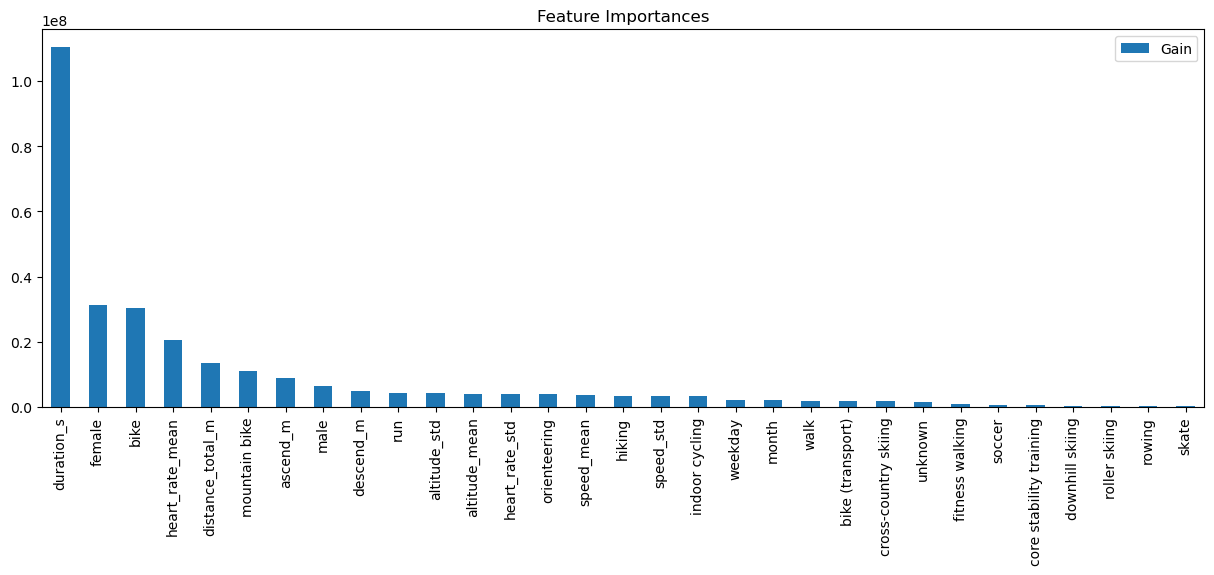

In [18]:
print('======== XGBR ===========')
print(f'Best={search.best_params_}, Best score = {search.best_score_}')

for metrics in all_metrics:
    print(f'{metrics.__name__} on Train set = {metrics(train_raw[target], y_train_pred_xgbr): .2e}')
    print(f'{metrics.__name__} on  Test set = {metrics(test_raw[target], y_test_pred_xgbr): .2e}')
R2 = r2_score(test_raw[target], y_test_pred_xgbr)
adjusted_R2 = 1.0 - (1.0 - R2)*(len(test_raw)-1.0)/(len(test_raw)-len(features))
print('======== XGBR ===========')
print(f"MAE = {mean_absolute_error(train_raw[target], y_train_pred_xgbr): .2e} \
      \nMSE = {mean_squared_error(test_raw[target], y_test_pred_xgbr): .2e}, \nR2 = {R2: .3f}")

feature_importances = pd.DataFrame.from_dict(search.best_estimator_['xgbr'].
                                             get_booster().get_score(importance_type="gain"),
                                             orient='index').rename(columns={0:'Gain'})
fig = plt.figure(figsize=(15,5), dpi=100)
feature_importances.sort_values(by=['Gain'],ascending = False).plot(kind='bar', title='Feature Importances', ax = plt.gca());

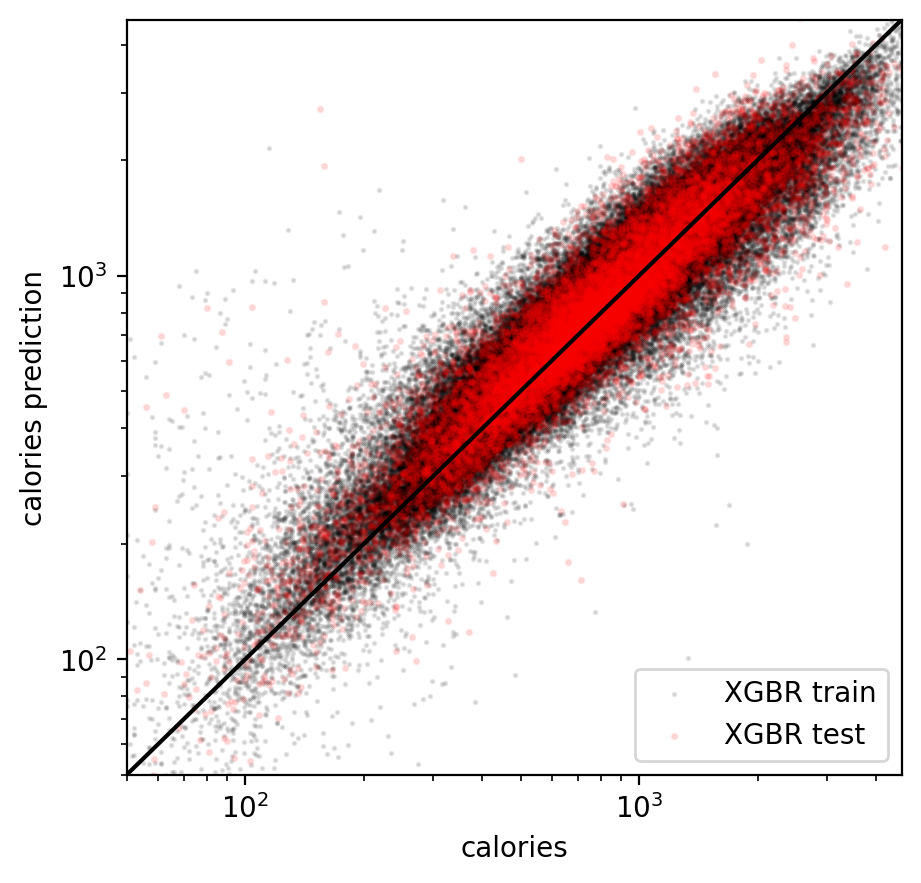

In [19]:
plt.figure(figsize=(5,5),dpi=200)
plt.scatter(train_raw[target], y_train_pred_xgbr, c = 'k', s = 1, alpha = 0.1, label ='XGBR train')
plt.scatter(test_raw[target], y_test_pred_xgbr, c = 'r', s = 3, alpha = 0.1, label ='XGBR test')

plt.plot(target_limit,target_limit, color = 'k', label = '' )
plt.xlabel(target), plt.ylabel(target + ' prediction'), 
plt.xscale('log'), plt.yscale('log')
plt.xlim(target_limit)
plt.ylim(target_limit)
plt.legend();

# Random Forest

In [20]:
'''
steps = [('transformer', Transformer()), 
         ('rfr', RandomForestRegressor())]

model = Pipeline(steps)
param_grid = {'rfr__n_estimators': [100], #[100,200,300]
              'rfr__max_depth':[10], # 3
              'rfr__min_samples_split':[2],# 2,10 
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid, 
                      cv = 5, n_jobs = -1, 
                      scoring = 'neg_mean_squared_error',
                      verbose=1, error_score = 'raise')
search.fit(train_raw[features], train_raw[target])
joblib.dump(search, 'gs_model_rfr.pkl')

print(f'Best={search.best_params_}')
'''
search = joblib.load("./trained_models/gs_model_rfr.pkl")
y_train_pred_rfr = search.predict(train_raw[features])
y_test_pred_rfr = search.predict(test_raw[features])

======== Random Forest ===========
Best={'rfr__max_depth': 10, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 100}, Best score = -96411.70362852959
mean_absolute_error on Train set =  1.76e+02
mean_absolute_error on  Test set =  1.89e+02
mean_squared_error on Train set =  8.08e+04
mean_squared_error on  Test set =  1.05e+05
r2_score on Train set =  7.93e-01
r2_score on  Test set =  7.40e-01
======== Random Forest ===========
MAE =  1.76e+02       
MSE =  1.05e+05, 
R2 =  0.740


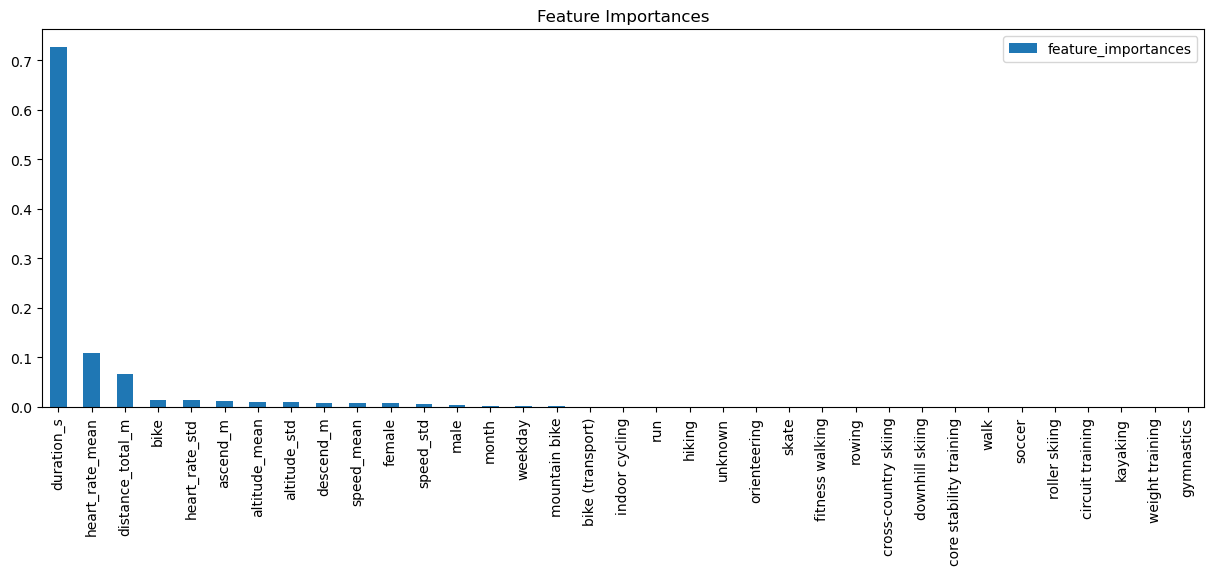

In [21]:
print('======== Random Forest ===========')
print(f'Best={search.best_params_}, Best score = {search.best_score_}')

for metrics in all_metrics:
    print(f'{metrics.__name__} on Train set = {metrics(train_raw[target], y_train_pred_rfr): .2e}')
    print(f'{metrics.__name__} on  Test set = {metrics(test_raw[target], y_test_pred_rfr): .2e}')
R2 = r2_score(test_raw[target], y_test_pred_rfr)
adjusted_R2 = 1.0 - (1.0 - R2)*(len(test_raw)-1.0)/(len(test_raw)-len(features))
print('======== Random Forest ===========')
print(f"MAE = {mean_absolute_error(train_raw[target], y_train_pred_rfr): .2e} \
      \nMSE = {mean_squared_error(test_raw[target], y_test_pred_rfr): .2e}, \nR2 = {R2: .3f}")

feature_importances = pd.DataFrame(data=search.best_estimator_['rfr'].feature_importances_,
                                  index=search.best_estimator_['rfr'].feature_names_in_,
                                  columns=['feature_importances'])

fig = plt.figure(figsize=(15,5), dpi=100)
feature_importances.sort_values(by=['feature_importances'], ascending=False).plot(kind='bar', title='Feature Importances', ax = plt.gca());

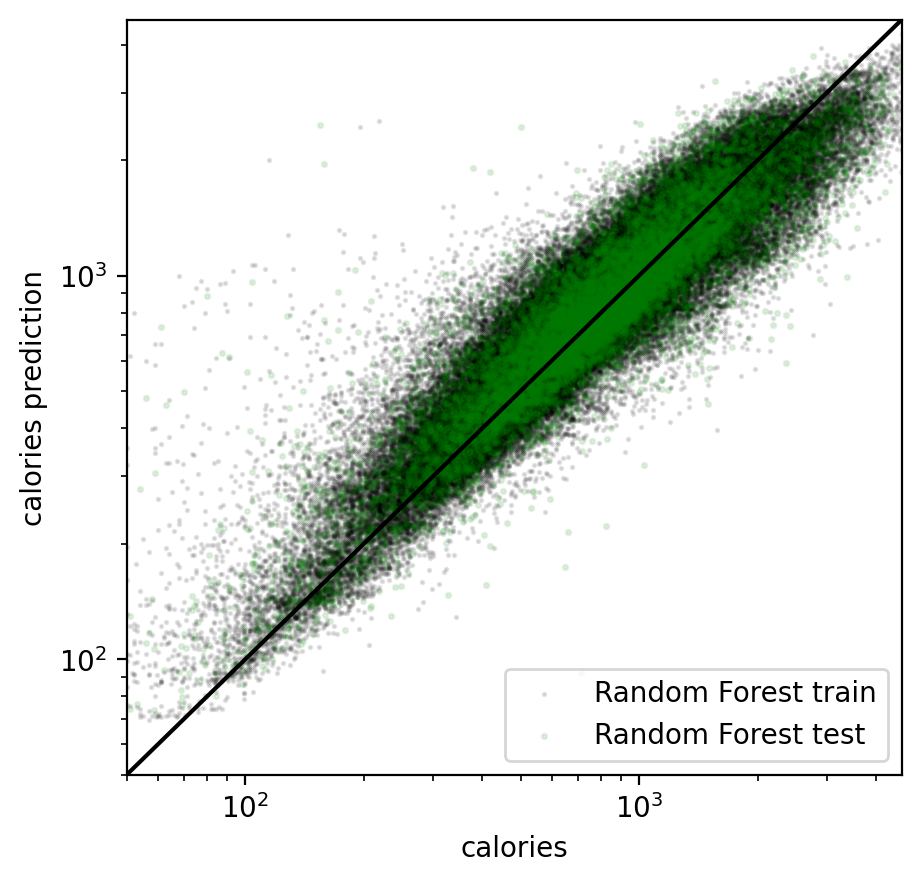

In [22]:
plt.figure(figsize=(5,5),dpi=200)
plt.plot(target_limit, target_limit, color = 'k', label = '' )
plt.scatter(train_raw[target], y_train_pred_rfr, c = 'k', s = 1, alpha = 0.1, label ='Random Forest train')
plt.scatter(test_raw[target], y_test_pred_rfr, c = 'g', s = 3, alpha = 0.1, label ='Random Forest test')
plt.xlabel(target), plt.ylabel(target + ' prediction'), 
plt.xscale('log'), plt.yscale('log')
plt.xlim(target_limit), plt.ylim(target_limit)
plt.legend();

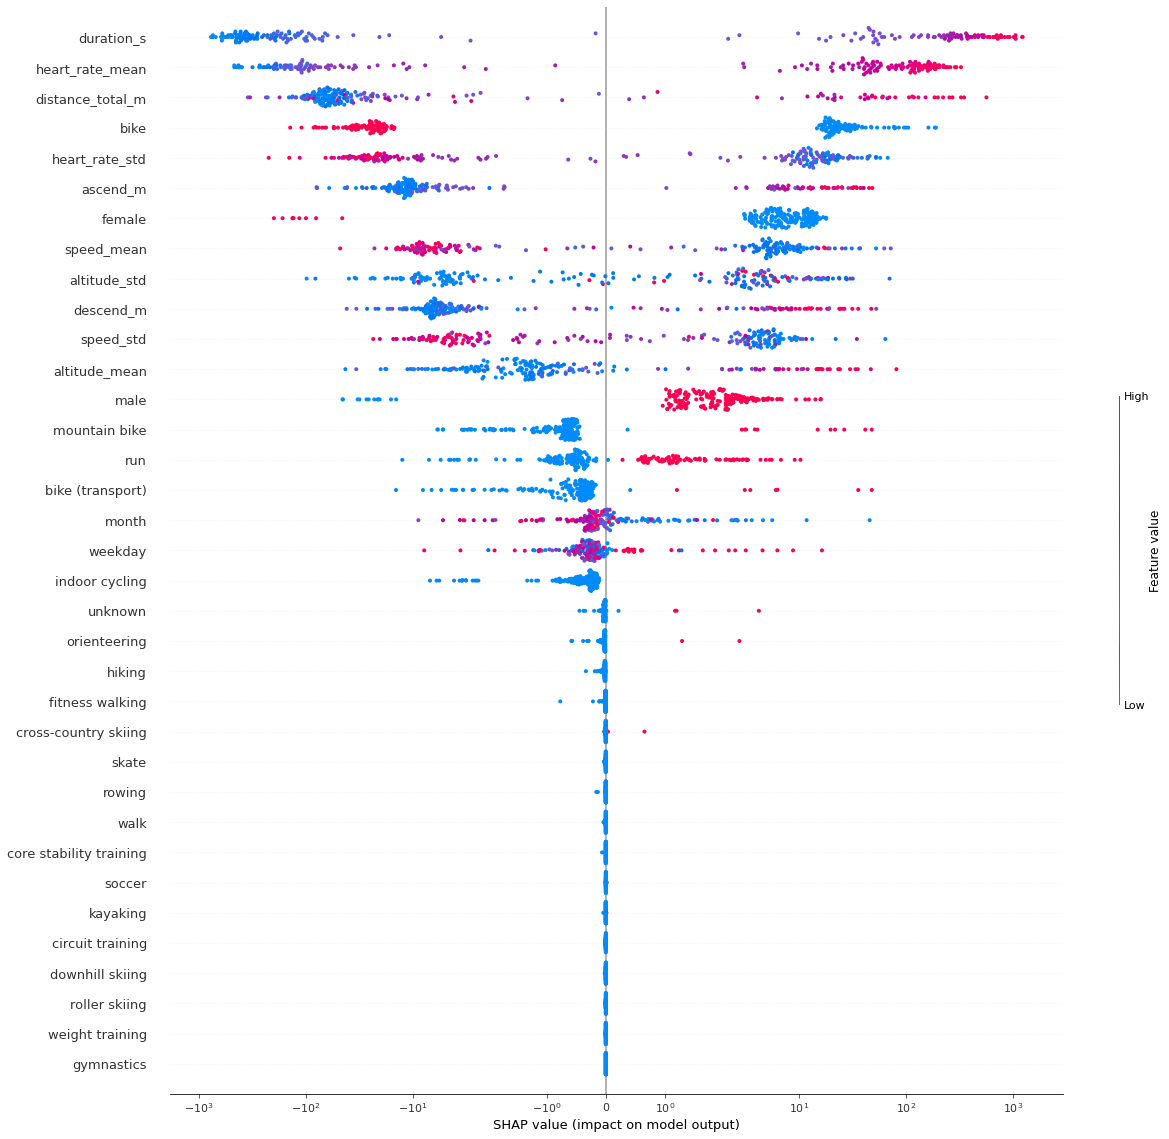

In [23]:
import shap
shap.initjs()
shap_model = search.best_estimator_['rfr']
X_test = Transformer().fit_transform(test_raw[features][:200])

shap_values = shap.TreeExplainer(shap_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_size = (20,20), max_display=len(X_test), use_log_scale = True)

# Multiclass Classification
* To predict the sport type based on other features

## Classify with simple logistic regression

In [24]:
from Utils.label_encoder import label_encoder
'''
class label_encoder(object):
    def __init__(self, df=None):
        # unique label, counts in descending order
        self.sports = list(df.sport.value_counts(ascending=False).index) 
        self.dmap = {sport:i for i,sport in enumerate(self.sports)}
        self.dmap_inverse = {i:sport for i,sport in enumerate(self.sports)}
        
    def encoder(self, labels):
        return list(map(lambda x:self.dmap[x], labels))

    def decoder(self, codes):
        return list(map(lambda x:self.dmap_inverse[x], codes)) 
'''
code = label_encoder(df_raw).encoder(['bike','run'])
decode = label_encoder(df_raw).decoder(code)
code, decode

([0, 1], ['bike', 'run'])

In [25]:
target = 'sport'
features = ['sport', 'gender', 'heart_rate_mean', 'heart_rate_std', 'altitude_mean',
           'altitude_std', 'ascend_m', 'descend_m', 'distance_total_m',
           'speed_mean', 'speed_std', 'duration_s', 'calories', 'start_time']

features.remove(target)

In [26]:
# split train test, remember to stratify according to the categorical variables
train_raw, test_raw = train_test_split(df_raw, test_size=0.1, random_state=42, stratify = df_raw[target] ) #['sport','gender']
print(df_raw.shape, train_raw.shape, test_raw.shape)

(163955, 21) (147559, 21) (16396, 21)


In [27]:
LE = label_encoder(df_raw)
y_train =  LE.encoder(train_raw[target])
y_test = LE.encoder(test_raw[target])

In [ ]:
#joblib.dump(search, 'gs_model_lor.joblib')

In [28]:
'''
steps = [('transformer', Transformer()), 
         ('rescale',RobustScaler()),
         ('lor', LogisticRegression(penalty='l2', multi_class = 'ovr', solver='sag', class_weight='balanced',max_iter=10))] #

model = Pipeline(steps)
param_grid = {'lor__C': [10], # 0.1, 1, 10
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid,
                      cv = 5, n_jobs = -1, 
                      scoring = 'roc_auc_ovr', verbose=1)

search.fit(train_raw[features], y_train)
joblib.dump(search, 'gs_model_lor.pkl')

print(f'Best={search.best_params_}')

'''
search = joblib.load("./trained_models/gs_model_lor.pkl")
search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        <Utils.Transformer.Transformer object at 0x7fce0304a520>),
                                       ('rescale', RobustScaler()),
                                       ('lor',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=20,
                                                           multi_class='ovr',
                                                           solver='sag'))]),
             n_jobs=-1, param_grid={'lor__C': [10]}, scoring='roc_auc_ovr',
             verbose=1)

======== Logistic Regression ==========
AUC ROC averaged on Train = 0.930
AUC ROC averaged on  Test = 0.929
=====================Logistic Regression Train =====================
              precision    recall  f1-score   support

           0       0.88      0.76      0.82     62893
           1       0.93      0.87      0.90     62823
           2       0.48      0.34      0.40      9608
           3       0.26      0.35      0.30      6874
           4       0.05      0.01      0.02      1124
           5       0.31      0.46      0.37      1113
           6       0.01      0.01      0.01       780
           7       0.10      0.44      0.16       707
           8       0.01      0.02      0.01       365
           9       0.09      0.39      0.15       262
          10       0.01      0.18      0.03       231
          11       0.03      0.49      0.06       214
          12       0.13      0.48      0.21       212
          13       0.01      0.04      0.01        73
          14

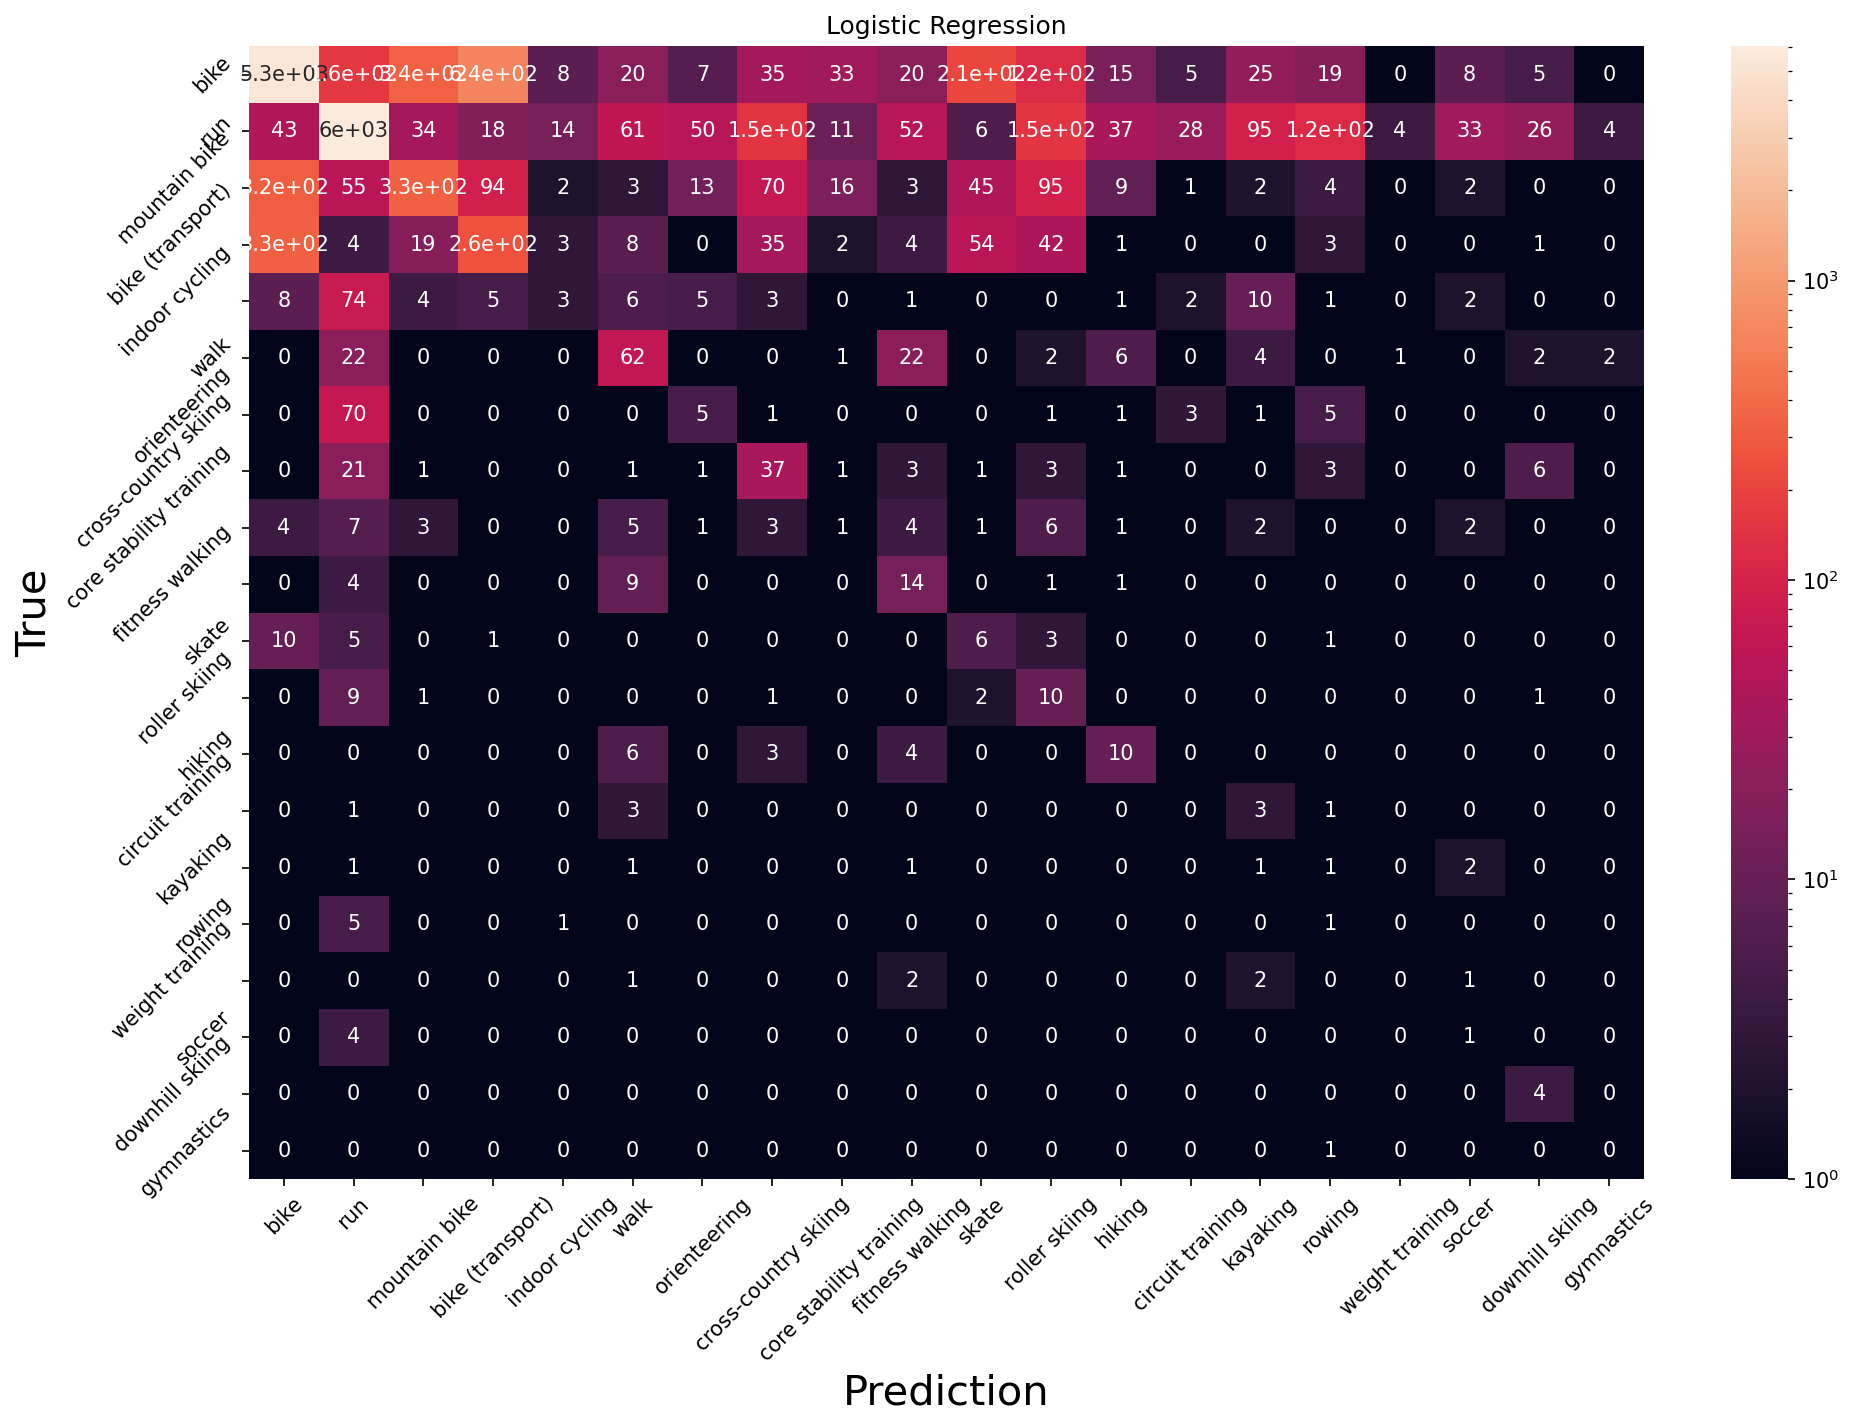

In [29]:
search = joblib.load("gs_model_lor.pkl")
y_train_pred_lor = search.predict(train_raw[features])
y_test_pred_lor = search.predict(test_raw[features])
y_train_pred_proba_lor = search.predict_proba(train_raw[features])
y_test_pred_proba_lor = search.predict_proba(test_raw[features])

print('======== Logistic Regression ==========')
ruc_train = roc_auc_score(y_train, y_train_pred_proba_lor, average='weighted', multi_class='ovr')
ruc_test = roc_auc_score(y_test, y_test_pred_proba_lor, average='weighted', multi_class='ovr')
print(f'AUC ROC averaged on Train ={ruc_train: .3f}')
print(f'AUC ROC averaged on  Test ={ruc_test: .3f}')

print('=====================Logistic Regression Train =====================')
print(classification_report(y_train,y_train_pred_lor))
print('=====================Logistic Regression  Test =====================')
print(classification_report(y_test,y_test_pred_lor))

cm_lor = confusion_matrix(y_test, y_test_pred_lor)
fig, ax = plt.subplots(figsize=(15,10),dpi=150) 
sns.heatmap(cm_lor, annot=True, norm=LogNorm(vmin=1.0, clip=True), ax=ax); # heatmap in log scale
ax.set_xticklabels(LE.sports, rotation=45)
ax.set_yticklabels(LE.sports, rotation=45)
plt.title('Logistic Regression')
plt.xlabel('Prediction', fontsize=20), plt.ylabel('True', fontsize=20);

## Classify with SVM

In [30]:
'''
steps = [('transformer', Transformer()), 
         ('rescale',MinMaxScaler()),
         ('svc', SVC(kernel='rbf', decision_function_shape='ovr', probability=True, max_iter=20))] #=

model = Pipeline(steps)
param_grid = {'svc__C': [10], # 0.1, 1, 10
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid,
                      cv = 5, n_jobs = -1, 
                      scoring = 'roc_auc_ovr', verbose=1)

search.fit(train_raw[features], y_train)
joblib.dump(search, 'gs_model_svc.pkl')

print(f'Best={search.best_params_}')
'''
search = joblib.load("./trained_models/gs_model_svc.pkl")
search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        <Utils.Transformer.Transformer object at 0x7fce0304a6d0>),
                                       ('rescale', MinMaxScaler()),
                                       ('svc',
                                        SVC(max_iter=20, probability=True))]),
             n_jobs=-1, param_grid={'svc__C': [10]}, scoring='roc_auc_ovr',
             verbose=1)

In [31]:
#y_train_pred_svc = search.predict(train_raw[features])
y_test_pred_svc = search.predict(test_raw[features])
#y_train_pred_proba_svc = search.predict_proba(train_raw[features])
y_test_pred_proba_svc = search.predict_proba(test_raw[features])

print('======== SVM ==========')
#ruc_train = roc_auc_score(y_train, y_train_pred_proba_svc, average='weighted', multi_class='ovr')
ruc_test = roc_auc_score(y_test, y_test_pred_proba_svc, average='weighted', multi_class='ovr')
#print(f'AUC ROC averaged on Train ={ruc_train: .3f}')
print(f'AUC ROC averaged on  Test ={ruc_test: .3f}')

#print('=====================SVM Train =====================')
#print(classification_report(y_train,y_train_pred_svc))
print('=====================SVM  Test =====================')
print(classification_report(y_test,y_test_pred_svc))

======== SVM ==========
AUC ROC averaged on  Test = 0.516
=====================SVM  Test =====================
              precision    recall  f1-score   support

           0       0.40      0.11      0.17      6988
           1       0.56      0.01      0.02      6981
           2       0.10      0.07      0.08      1068
           3       0.00      0.00      0.00       764
           4       0.01      0.06      0.02       125
           5       0.08      0.02      0.04       124
           6       0.00      0.00      0.00        87
           7       0.00      0.00      0.00        79
           8       0.00      0.00      0.00        40
           9       0.00      0.00      0.00        29
          10       0.00      0.00      0.00        26
          11       0.00      0.46      0.00        24
          12       0.01      0.30      0.03        23
          13       0.01      0.25      0.02         8
          14       0.00      0.14      0.00         7
          15       0.00 

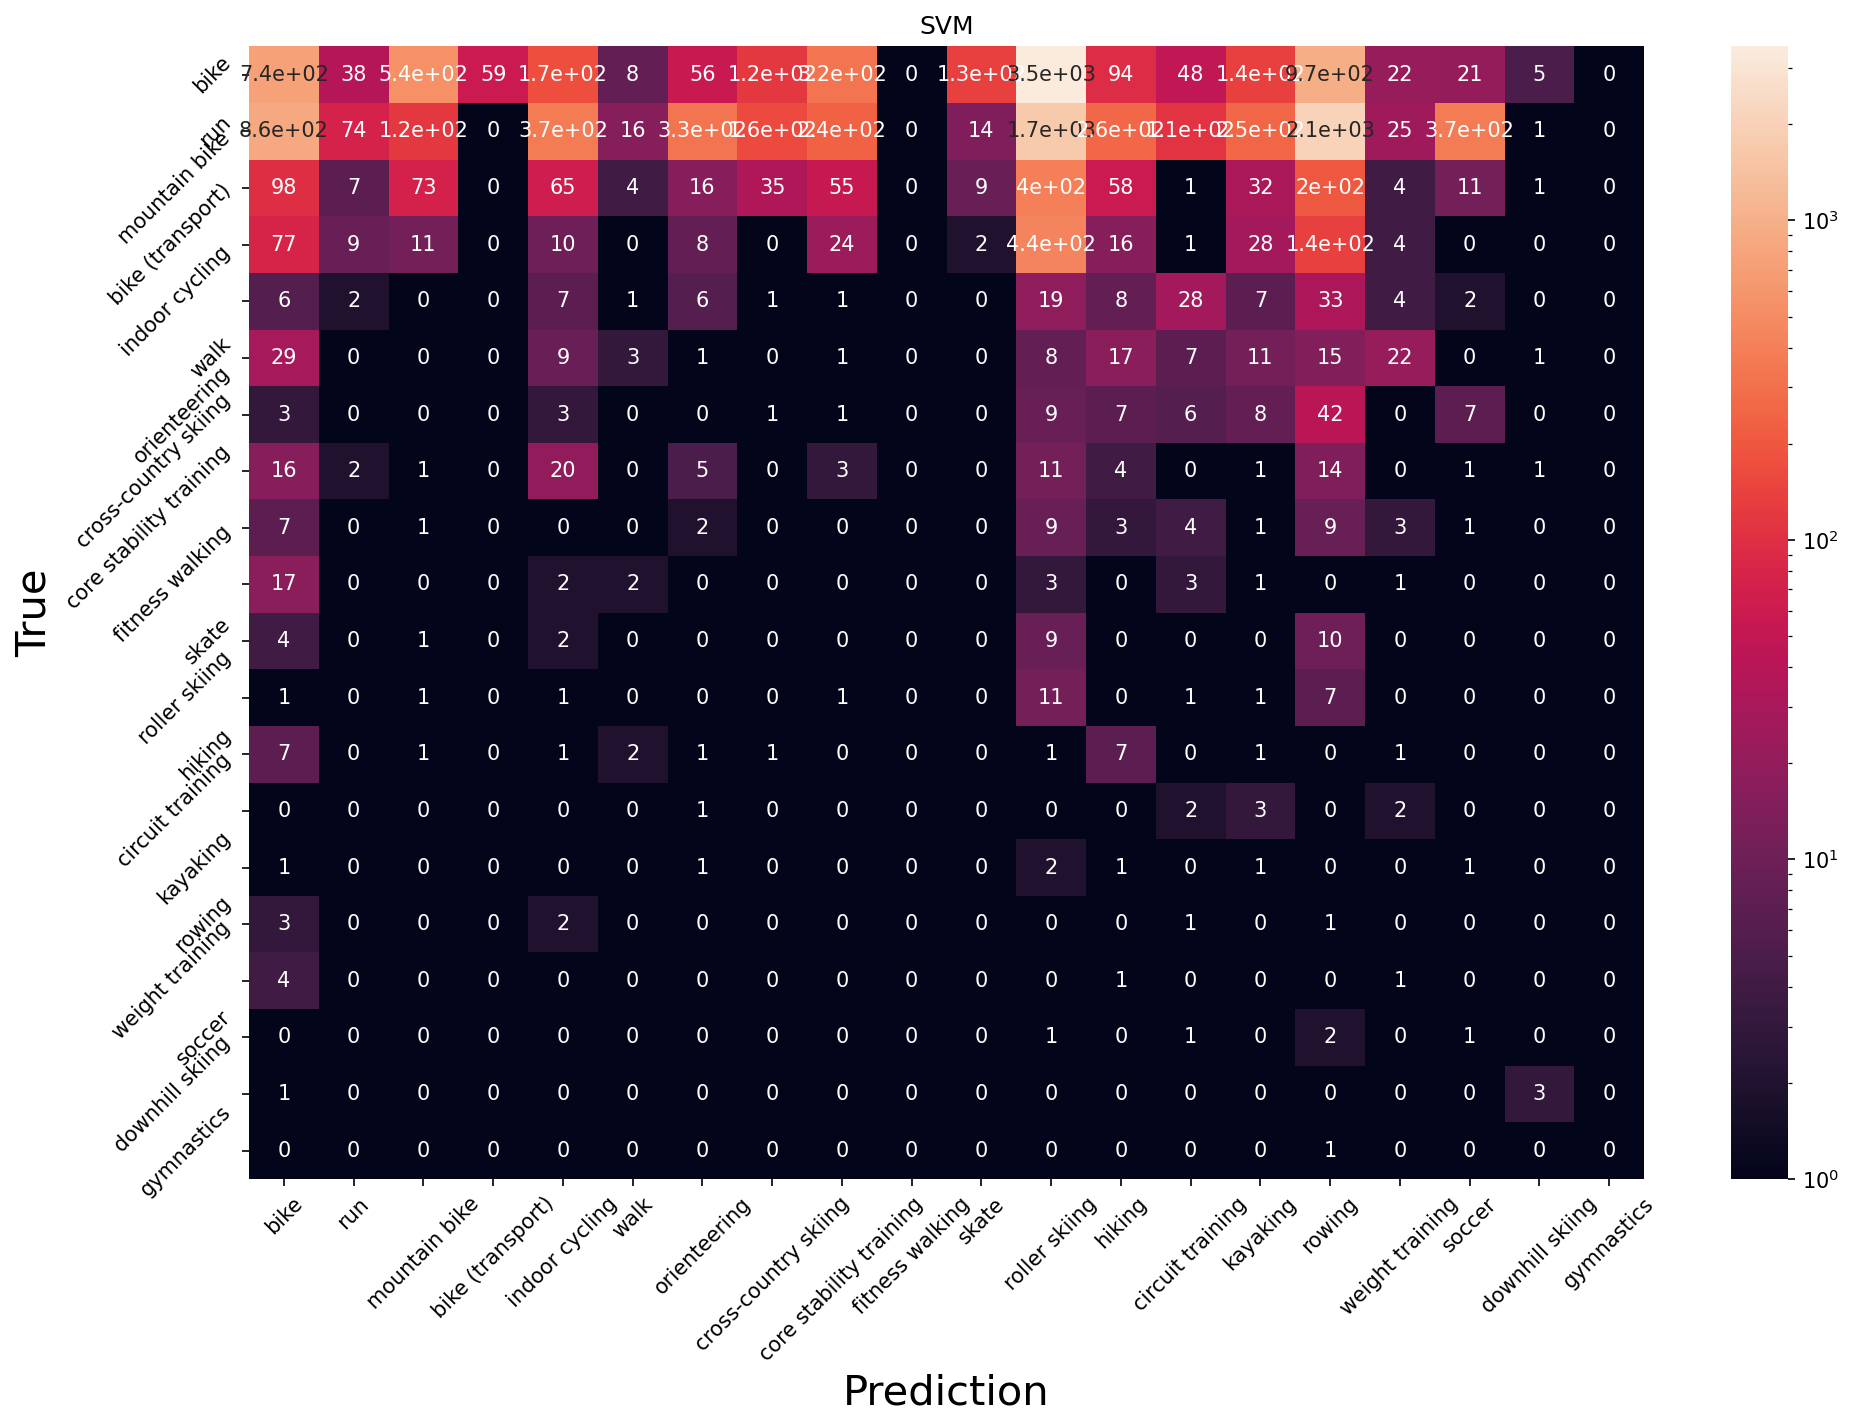

In [32]:
cm_svc = confusion_matrix(y_test, y_test_pred_svc)
fig, ax = plt.subplots(figsize=(15,10),dpi=150) 
sns.heatmap(cm_svc, annot=True, norm=LogNorm(vmin=1.0, clip=True), ax=ax); # heatmap in log scale
ax.set_xticklabels(LE.sports, rotation=45)
ax.set_yticklabels(LE.sports, rotation=45)
plt.title('SVM')
plt.xlabel('Prediction', fontsize=20), plt.ylabel('True', fontsize=20);

# XGBoost Classifier

In [33]:
'''
steps = [('transformer', Transformer()), 
         ('xgbc', XGBClassifier(objective='multi:softprob', max_iter=20))]

model = Pipeline(steps)
param_grid = {'xgbc__n_estimators': [300], #50, 150, 300
              'xgbc__learning_rate':[0.15], #0.05, 0.15
              'xgbc__max_depth':[5], # 3, 5
              'xgbc__gamma':[0.5],
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid, 
                      cv =  5, n_jobs = -1, 
                      scoring = 'roc_auc_ovr', verbose=1)

search.fit(train_raw[features], y_train)
joblib.dump(search, 'gs_model_xgbc.pkl')

print(f'Best={search.best_params_}')
'''
search = joblib.load("./trained_models/gs_model_xgbc.pkl")
search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        <Utils.Transformer.Transformer object at 0x7fce017dbd00>),
                                       ('xgbc',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
               

In [35]:
y_train_pred_xgbc = search.predict(train_raw[features])
y_test_pred_xgbc = search.predict(test_raw[features])

y_train_pred_proba_xgbc = search.predict_proba(train_raw[features])
y_test_pred_proba_xgbc = search.predict_proba(test_raw[features])

print('======== XGBClassifier ==========')
ruc_train = roc_auc_score(y_train, y_train_pred_proba_xgbc, average='weighted', multi_class='ovr')
ruc_test = roc_auc_score(y_test, y_test_pred_proba_xgbc, average='weighted', multi_class='ovr')
print(f'AUC ROC averaged on Train ={ruc_train: .3f}')
print(f'AUC ROC averaged on  Test ={ruc_test: .3f}')

print('=====================XGBClassifier Train =====================')
print(classification_report(y_train,y_train_pred_xgbc))
print('=====================XGBClassifier  Test =====================')
print(classification_report(y_test,y_test_pred_xgbc))

======== XGBClassifier ==========
AUC ROC averaged on Train = 0.994
AUC ROC averaged on  Test = 0.985
=====================XGBClassifier Train =====================
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     62893
           1       0.99      0.99      0.99     62823
           2       0.83      0.66      0.73      9608
           3       0.94      0.73      0.83      6874
           4       0.98      0.97      0.97      1124
           5       0.98      0.98      0.98      1113
           6       0.96      0.86      0.91       780
           7       0.96      0.90      0.93       707
           8       0.98      0.85      0.91       365
           9       1.00      0.97      0.98       262
          10       1.00      0.86      0.92       231
          11       1.00      0.94      0.97       214
          12       0.98      0.99      0.98       212
          13       1.00      1.00      1.00        73
          14       1.00 

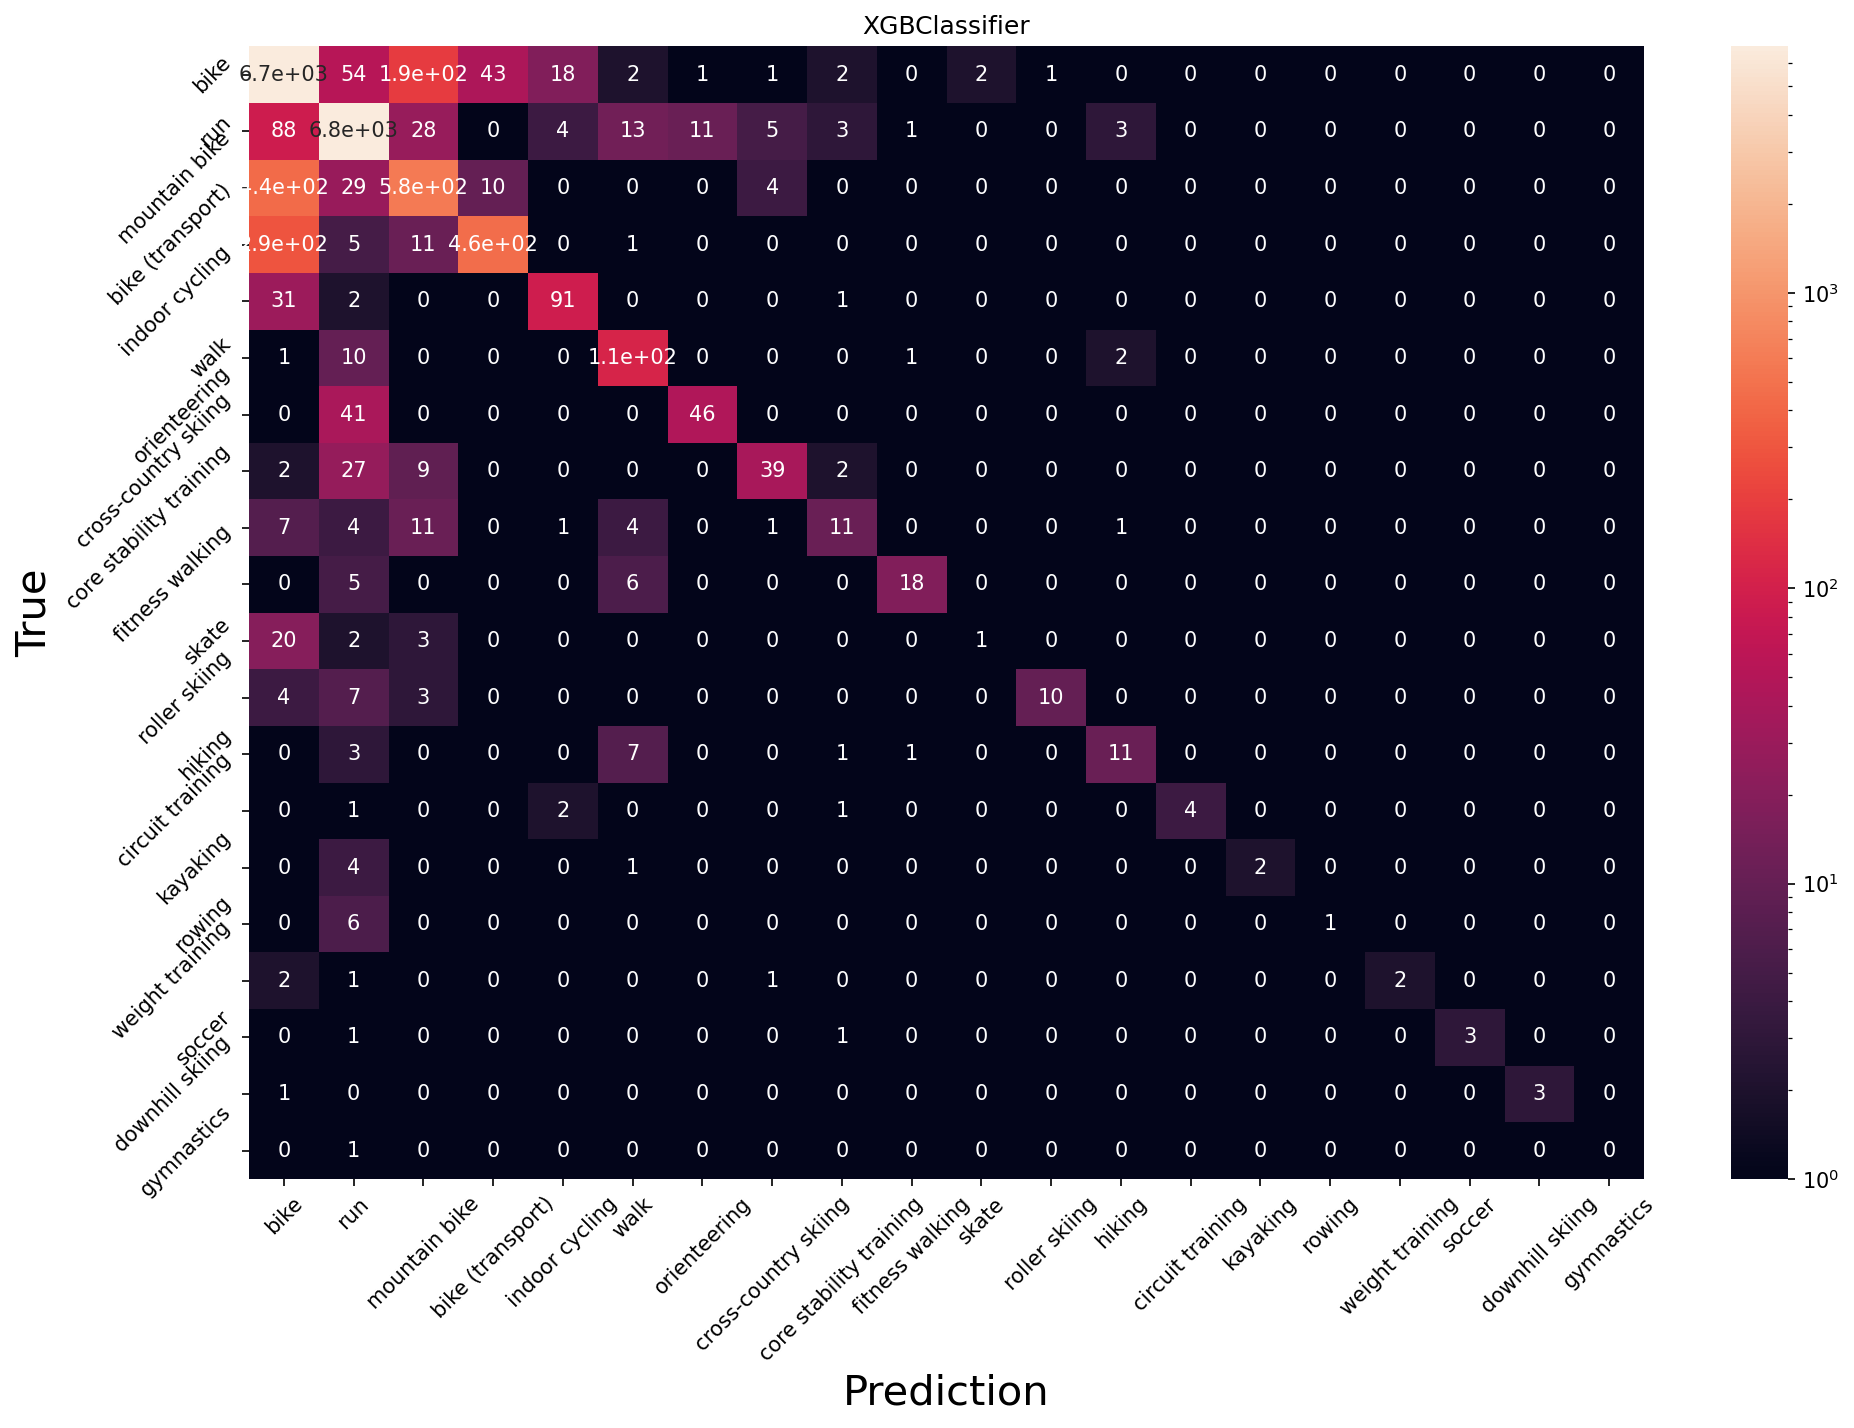

In [36]:
cm_xgbc = confusion_matrix(y_test, y_test_pred_xgbc)
fig, ax = plt.subplots(figsize=(15,10),dpi=150)
sns.heatmap(cm_xgbc, annot=True, norm=LogNorm(vmin=1.0, clip=True), ax=ax); # heatmap in log scale
ax.set_xticklabels(LE.sports, rotation=45)
ax.set_yticklabels(LE.sports, rotation=45)
plt.title('XGBClassifier')
plt.xlabel('Prediction', fontsize=20), plt.ylabel('True', fontsize=20);

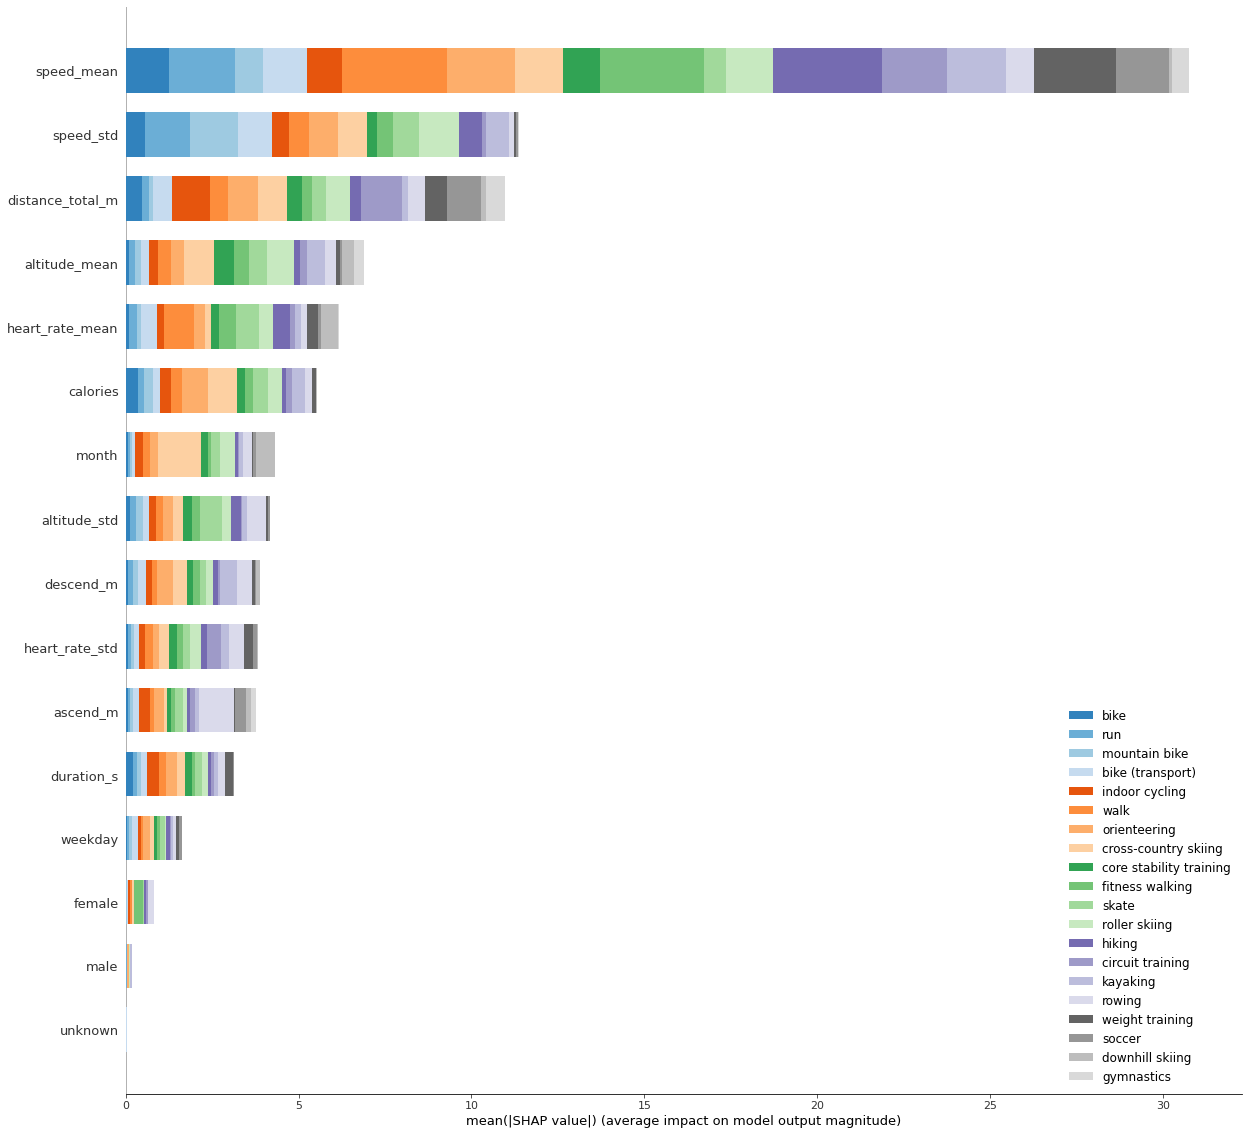

In [37]:
import shap
import matplotlib.pyplot as plt
shap.initjs()
shap_model = search.best_estimator_['xgbc']
X_test = Transformer().fit_transform(test_raw[features][:200])

shap_values = shap.TreeExplainer(shap_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_size = (20,20), 
                  max_display=len(X_test),class_inds='original',
                  color=plt.get_cmap("tab20c"),class_names= LE.sports)

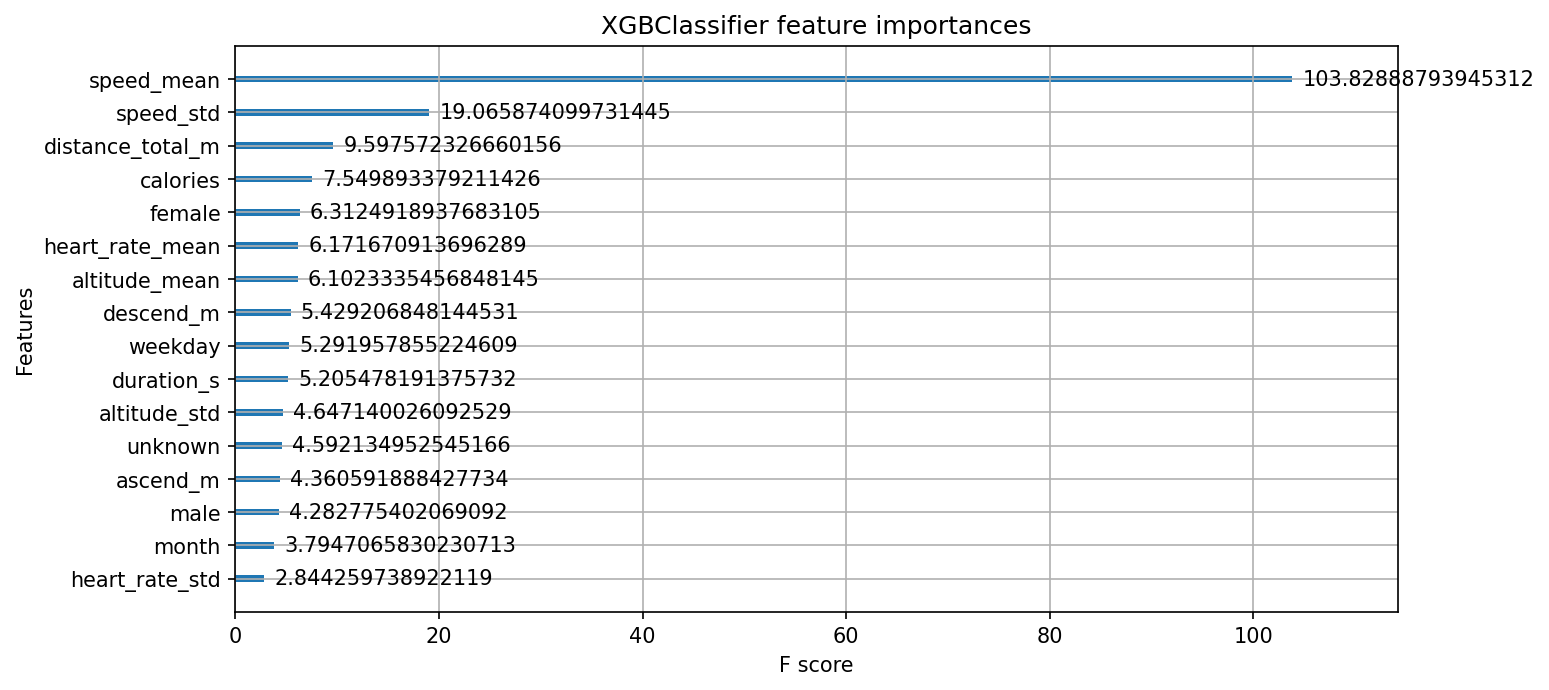

In [38]:
fig, ax = plt.subplots(figsize=(10,5),dpi=150) 
xgboost.plot_importance(search.best_estimator_['xgbc'], importance_type="gain", ax=ax)
plt.title("XGBClassifier feature importances");